In [1]:
#%%
import numpy as np
import pandas as pd
import random
import copy

from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
class GAN(object):
    
    def __init__(self, height= 10, channels = 1):

        self.SHAPE = (height,channels)
        self.HEIGHT = height
        self.CHANNELS = channels

        self.OPTIMIZER = Adam(lr=0.0002, beta_1 = 0.5,decay=8e-9)

        self.G = self._generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        self.D = self._discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'])

        self.stacked_G_D = self._stacked_G_D()

        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        self.G_loss = []
        self.D_C_loss = []
        self.D_S_loss = []
        self.EPOCHS = 2000
    def _generator(self):

        model = Sequential()
        #input layer
        model.add(Dense(20, input_shape = (self.HEIGHT,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #layer 2
        model.add(Dense(40))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(40))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #layer 3
        model.add(Dense(20))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(10, activation='tanh'))

        model.add(Reshape(self.SHAPE))
        
        return model

    def _discriminator(self):

        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(np.int64((self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(np.int64((self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def _stacked_G_D(self):
        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model
        
    def train(self, data, epochs = 2000,batch = 6, sparse_clean_ratio = 0.3):
        self.EPOCHS = epochs
        for epoch in range(epochs):
            
            # train discriminator
            random_index = np.random.randint(0, len(data) - batch//2)
            clean_mixes = copy.deepcopy(data[random_index : random_index + batch//2])
            
            # create sparse mixes
            sparse_mix = copy.deepcopy(clean_mixes)
            for mix in sparse_mix:
                rand_indexs = np.random.randint(0,len(mix),round(len(mix)*sparse_clean_ratio))
                for i in rand_indexs:
                    mix[i]=0
            
            #print(sparse_mix)
            #print(scaled_data)
            synthetic_mixes = self.G.predict_on_batch(sparse_mix)

            # combined_batch = np.concatenate((clean_mixes.reshape(synthetic_mixes.shape),synthetic_mixes))
            # mask_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            # d_loss = self.D.train_on_batch(combined_batch, mask_batch)
            d_loss_clean = self.D.train_on_batch(clean_mixes.reshape(synthetic_mixes.shape),np.ones((np.int64(batch/2), 1)))
            d_loss_synthetic = self.D.train_on_batch(synthetic_mixes,np.zeros((np.int64(batch/2), 1)))

            
            # train generator
            random_index = np.random.randint(0, len(data), size = (1,batch))
            sparse_mix = copy.deepcopy(data[random_index])
            for mix in sparse_mix:
                rand_indexs = np.random.randint(0,high=len(mix),size=round(len(mix)*sparse_clean_ratio))
                mix[rand_indexs] = 0
            y_label = np.ones((batch,1))

            g_loss = self.stacked_G_D.train_on_batch(np.squeeze(sparse_mix),y_label)

            self.G_loss.append(g_loss)
            self.D_C_loss.append(d_loss_clean[0])
            self.D_S_loss.append(d_loss_synthetic[0])
            print ('epoch: %d, [Discriminator :: loss: %f,%f], [ Generator :: loss: %f]' % (epoch, d_loss_clean[0],d_loss_synthetic[0], g_loss))
    def plot(self):
        import matplotlib.pyplot as plt
        plt.style.use('seaborn-whitegrid')
        
        fig = plt.figure()
        ax = plt.axes()

        x = range(self.EPOCHS)
        ax.plot(x,self.G_loss, color = 'orange', label = "Generator")
        ax.plot(x,self.D_C_loss, 'b-', alpha = 0.5, label = "Discriminator - Clean")
        ax.plot(x,self.D_S_loss, 'g-', alpha = 0.5, label = "Discriminator - Synthetic")
        ax.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        plt.show()

In [3]:

if __name__ == '__main__':

    # set random seed
    random.seed(1)
    
    
    # Load data from CSV file
    data = pd.read_csv("~/Desktop/Concrete-NN/data/ets.csv", dtype=float)
    # Removing cost for now as it is not important
    data = data.drop('Cost ($/m3)',1)
    # Creating Scaler
    scaler = MinMaxScaler(feature_range = (-1,1))
    # scaling datas
    scaled_data = scaler.fit_transform(data)
    np.random.shuffle(scaled_data)
    gan = GAN()
    gan.train(scaled_data, epochs=7000,batch = 6,sparse_clean_ratio=0.2)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 30        
_________________________________________________________________
leak

/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: loss: 0.969576,0.680312], [ Generator :: loss: 1.103784]
epoch: 1, [Discriminator :: loss: 0.911613,0.491528], [ Generator :: loss: 1.017818]
epoch: 2, [Discriminator :: loss: 0.946038,0.317923], [ Generator :: loss: 1.002424]
epoch: 3, [Discriminator :: loss: 0.947151,0.354853], [ Generator :: loss: 1.098847]
epoch: 4, [Discriminator :: loss: 0.885983,0.478814], [ Generator :: loss: 1.013547]
epoch: 5, [Discriminator :: loss: 0.941628,0.489123], [ Generator :: loss: 0.995332]
epoch: 6, [Discriminator :: loss: 1.046306,0.540721], [ Generator :: loss: 1.033437]
epoch: 7, [Discriminator :: loss: 0.881949,0.497035], [ Generator :: loss: 1.117166]
epoch: 8, [Discriminator :: loss: 0.960707,0.474364], [ Generator :: loss: 0.968089]
epoch: 9, [Discriminator :: loss: 0.937847,0.504682], [ Generator :: loss: 0.997881]
epoch: 10, [Discriminator :: loss: 0.900422,0.542477], [ Generator :: loss: 0.961504]
epoch: 11, [Discriminator :: loss: 0.958015,0.434039], [ Generat

epoch: 117, [Discriminator :: loss: 0.815762,0.603250], [ Generator :: loss: 0.833598]
epoch: 118, [Discriminator :: loss: 0.800931,0.636743], [ Generator :: loss: 0.885988]
epoch: 119, [Discriminator :: loss: 0.808169,0.610297], [ Generator :: loss: 0.854637]
epoch: 120, [Discriminator :: loss: 0.781818,0.559683], [ Generator :: loss: 0.829028]
epoch: 121, [Discriminator :: loss: 0.859511,0.620132], [ Generator :: loss: 0.854313]
epoch: 122, [Discriminator :: loss: 0.880175,0.633352], [ Generator :: loss: 0.842588]
epoch: 123, [Discriminator :: loss: 0.837095,0.474154], [ Generator :: loss: 0.815474]
epoch: 124, [Discriminator :: loss: 0.965771,0.561903], [ Generator :: loss: 0.849644]
epoch: 125, [Discriminator :: loss: 0.838026,0.562427], [ Generator :: loss: 0.843770]
epoch: 126, [Discriminator :: loss: 0.839974,0.595854], [ Generator :: loss: 0.864000]
epoch: 127, [Discriminator :: loss: 0.754858,0.624929], [ Generator :: loss: 0.831063]
epoch: 128, [Discriminator :: loss: 0.80933

epoch: 233, [Discriminator :: loss: 0.806379,0.666453], [ Generator :: loss: 0.830481]
epoch: 234, [Discriminator :: loss: 0.812560,0.605494], [ Generator :: loss: 0.790053]
epoch: 235, [Discriminator :: loss: 0.784692,0.601731], [ Generator :: loss: 0.826866]
epoch: 236, [Discriminator :: loss: 0.818423,0.600456], [ Generator :: loss: 0.802659]
epoch: 237, [Discriminator :: loss: 0.777748,0.603972], [ Generator :: loss: 0.789620]
epoch: 238, [Discriminator :: loss: 0.775494,0.612388], [ Generator :: loss: 0.785314]
epoch: 239, [Discriminator :: loss: 0.770241,0.600779], [ Generator :: loss: 0.781352]
epoch: 240, [Discriminator :: loss: 0.822597,0.554547], [ Generator :: loss: 0.785434]
epoch: 241, [Discriminator :: loss: 0.795394,0.647207], [ Generator :: loss: 0.752920]
epoch: 242, [Discriminator :: loss: 0.781520,0.599254], [ Generator :: loss: 0.752117]
epoch: 243, [Discriminator :: loss: 0.816845,0.573189], [ Generator :: loss: 0.791561]
epoch: 244, [Discriminator :: loss: 0.76497

epoch: 350, [Discriminator :: loss: 0.701564,0.650289], [ Generator :: loss: 0.829145]
epoch: 351, [Discriminator :: loss: 0.735774,0.618408], [ Generator :: loss: 0.772757]
epoch: 352, [Discriminator :: loss: 0.789750,0.604718], [ Generator :: loss: 0.777412]
epoch: 353, [Discriminator :: loss: 0.705150,0.658477], [ Generator :: loss: 0.758461]
epoch: 354, [Discriminator :: loss: 0.743554,0.599179], [ Generator :: loss: 0.773343]
epoch: 355, [Discriminator :: loss: 0.736696,0.584767], [ Generator :: loss: 0.811262]
epoch: 356, [Discriminator :: loss: 0.754874,0.605642], [ Generator :: loss: 0.796271]
epoch: 357, [Discriminator :: loss: 0.772178,0.513355], [ Generator :: loss: 0.774162]
epoch: 358, [Discriminator :: loss: 0.833584,0.540881], [ Generator :: loss: 0.786086]
epoch: 359, [Discriminator :: loss: 0.773115,0.580324], [ Generator :: loss: 0.745354]
epoch: 360, [Discriminator :: loss: 0.758353,0.611931], [ Generator :: loss: 0.781613]
epoch: 361, [Discriminator :: loss: 0.75413

epoch: 479, [Discriminator :: loss: 0.735222,0.594543], [ Generator :: loss: 0.757336]
epoch: 480, [Discriminator :: loss: 0.731189,0.625916], [ Generator :: loss: 0.775121]
epoch: 481, [Discriminator :: loss: 0.701791,0.637608], [ Generator :: loss: 0.761090]
epoch: 482, [Discriminator :: loss: 0.699650,0.604398], [ Generator :: loss: 0.746116]
epoch: 483, [Discriminator :: loss: 0.707512,0.602989], [ Generator :: loss: 0.794086]
epoch: 484, [Discriminator :: loss: 0.740032,0.661670], [ Generator :: loss: 0.733494]
epoch: 485, [Discriminator :: loss: 0.721524,0.606242], [ Generator :: loss: 0.740535]
epoch: 486, [Discriminator :: loss: 0.713149,0.610790], [ Generator :: loss: 0.793160]
epoch: 487, [Discriminator :: loss: 0.763559,0.572611], [ Generator :: loss: 0.740546]
epoch: 488, [Discriminator :: loss: 0.762711,0.650064], [ Generator :: loss: 0.800920]
epoch: 489, [Discriminator :: loss: 0.731179,0.662351], [ Generator :: loss: 0.808176]
epoch: 490, [Discriminator :: loss: 0.71258

epoch: 600, [Discriminator :: loss: 0.732723,0.645211], [ Generator :: loss: 0.781889]
epoch: 601, [Discriminator :: loss: 0.771209,0.589326], [ Generator :: loss: 0.759743]
epoch: 602, [Discriminator :: loss: 0.687240,0.611650], [ Generator :: loss: 0.758072]
epoch: 603, [Discriminator :: loss: 0.729209,0.548093], [ Generator :: loss: 0.751161]
epoch: 604, [Discriminator :: loss: 0.741190,0.666420], [ Generator :: loss: 0.764875]
epoch: 605, [Discriminator :: loss: 0.692622,0.572546], [ Generator :: loss: 0.759986]
epoch: 606, [Discriminator :: loss: 0.761742,0.647360], [ Generator :: loss: 0.773572]
epoch: 607, [Discriminator :: loss: 0.776693,0.682412], [ Generator :: loss: 0.753853]
epoch: 608, [Discriminator :: loss: 0.741555,0.587508], [ Generator :: loss: 0.788918]
epoch: 609, [Discriminator :: loss: 0.735607,0.616063], [ Generator :: loss: 0.743815]
epoch: 610, [Discriminator :: loss: 0.745202,0.640001], [ Generator :: loss: 0.725998]
epoch: 611, [Discriminator :: loss: 0.72577

epoch: 716, [Discriminator :: loss: 0.711499,0.580904], [ Generator :: loss: 0.765129]
epoch: 717, [Discriminator :: loss: 0.788984,0.529914], [ Generator :: loss: 0.734124]
epoch: 718, [Discriminator :: loss: 0.701927,0.679118], [ Generator :: loss: 0.719049]
epoch: 719, [Discriminator :: loss: 0.688980,0.699000], [ Generator :: loss: 0.732446]
epoch: 720, [Discriminator :: loss: 0.709528,0.653661], [ Generator :: loss: 0.736262]
epoch: 721, [Discriminator :: loss: 0.678012,0.650270], [ Generator :: loss: 0.772008]
epoch: 722, [Discriminator :: loss: 0.713875,0.643757], [ Generator :: loss: 0.767562]
epoch: 723, [Discriminator :: loss: 0.720945,0.510438], [ Generator :: loss: 0.756323]
epoch: 724, [Discriminator :: loss: 0.672311,0.615979], [ Generator :: loss: 0.733821]
epoch: 725, [Discriminator :: loss: 0.732412,0.631428], [ Generator :: loss: 0.741493]
epoch: 726, [Discriminator :: loss: 0.766774,0.634715], [ Generator :: loss: 0.771621]
epoch: 727, [Discriminator :: loss: 0.71975

epoch: 830, [Discriminator :: loss: 0.715920,0.667374], [ Generator :: loss: 0.728733]
epoch: 831, [Discriminator :: loss: 0.730607,0.692945], [ Generator :: loss: 0.732304]
epoch: 832, [Discriminator :: loss: 0.719107,0.663709], [ Generator :: loss: 0.720350]
epoch: 833, [Discriminator :: loss: 0.697789,0.684707], [ Generator :: loss: 0.730698]
epoch: 834, [Discriminator :: loss: 0.690109,0.628544], [ Generator :: loss: 0.718376]
epoch: 835, [Discriminator :: loss: 0.722904,0.622248], [ Generator :: loss: 0.735735]
epoch: 836, [Discriminator :: loss: 0.676724,0.706442], [ Generator :: loss: 0.704003]
epoch: 837, [Discriminator :: loss: 0.693071,0.684908], [ Generator :: loss: 0.699848]
epoch: 838, [Discriminator :: loss: 0.728067,0.628085], [ Generator :: loss: 0.734604]
epoch: 839, [Discriminator :: loss: 0.705020,0.593007], [ Generator :: loss: 0.763969]
epoch: 840, [Discriminator :: loss: 0.789114,0.682531], [ Generator :: loss: 0.789321]
epoch: 841, [Discriminator :: loss: 0.70960

epoch: 953, [Discriminator :: loss: 0.757964,0.668275], [ Generator :: loss: 0.707034]
epoch: 954, [Discriminator :: loss: 0.689309,0.707283], [ Generator :: loss: 0.696787]
epoch: 955, [Discriminator :: loss: 0.817634,0.653510], [ Generator :: loss: 0.747047]
epoch: 956, [Discriminator :: loss: 0.705602,0.627472], [ Generator :: loss: 0.692726]
epoch: 957, [Discriminator :: loss: 0.691806,0.674419], [ Generator :: loss: 0.709879]
epoch: 958, [Discriminator :: loss: 0.711367,0.616463], [ Generator :: loss: 0.709668]
epoch: 959, [Discriminator :: loss: 0.717521,0.668996], [ Generator :: loss: 0.707937]
epoch: 960, [Discriminator :: loss: 0.719193,0.649733], [ Generator :: loss: 0.715015]
epoch: 961, [Discriminator :: loss: 0.812909,0.685312], [ Generator :: loss: 0.702621]
epoch: 962, [Discriminator :: loss: 0.712825,0.658038], [ Generator :: loss: 0.693072]
epoch: 963, [Discriminator :: loss: 0.731233,0.674916], [ Generator :: loss: 0.708434]
epoch: 964, [Discriminator :: loss: 0.68760

epoch: 1075, [Discriminator :: loss: 0.823354,0.615498], [ Generator :: loss: 0.690602]
epoch: 1076, [Discriminator :: loss: 0.694520,0.648267], [ Generator :: loss: 0.691723]
epoch: 1077, [Discriminator :: loss: 0.661306,0.649252], [ Generator :: loss: 0.689436]
epoch: 1078, [Discriminator :: loss: 0.694980,0.706021], [ Generator :: loss: 0.684983]
epoch: 1079, [Discriminator :: loss: 0.684843,0.699855], [ Generator :: loss: 0.701010]
epoch: 1080, [Discriminator :: loss: 0.707222,0.609917], [ Generator :: loss: 0.694788]
epoch: 1081, [Discriminator :: loss: 0.734475,0.692784], [ Generator :: loss: 0.686260]
epoch: 1082, [Discriminator :: loss: 0.689533,0.646152], [ Generator :: loss: 0.696818]
epoch: 1083, [Discriminator :: loss: 0.704403,0.684923], [ Generator :: loss: 0.700710]
epoch: 1084, [Discriminator :: loss: 0.719240,0.718269], [ Generator :: loss: 0.711721]
epoch: 1085, [Discriminator :: loss: 0.727838,0.681545], [ Generator :: loss: 0.681041]
epoch: 1086, [Discriminator :: l

epoch: 1190, [Discriminator :: loss: 0.744493,0.709578], [ Generator :: loss: 0.683255]
epoch: 1191, [Discriminator :: loss: 0.725319,0.722585], [ Generator :: loss: 0.683285]
epoch: 1192, [Discriminator :: loss: 0.716302,0.660800], [ Generator :: loss: 0.682932]
epoch: 1193, [Discriminator :: loss: 0.736385,0.669386], [ Generator :: loss: 0.694339]
epoch: 1194, [Discriminator :: loss: 0.705054,0.691301], [ Generator :: loss: 0.680917]
epoch: 1195, [Discriminator :: loss: 0.751245,0.696999], [ Generator :: loss: 0.702523]
epoch: 1196, [Discriminator :: loss: 0.755749,0.685222], [ Generator :: loss: 0.682393]
epoch: 1197, [Discriminator :: loss: 0.670891,0.692898], [ Generator :: loss: 0.673476]
epoch: 1198, [Discriminator :: loss: 0.670695,0.684271], [ Generator :: loss: 0.673421]
epoch: 1199, [Discriminator :: loss: 0.715355,0.719958], [ Generator :: loss: 0.680647]
epoch: 1200, [Discriminator :: loss: 0.748848,0.686909], [ Generator :: loss: 0.680980]
epoch: 1201, [Discriminator :: l

epoch: 1291, [Discriminator :: loss: 0.698449,0.706627], [ Generator :: loss: 0.675586]
epoch: 1292, [Discriminator :: loss: 0.710217,0.722832], [ Generator :: loss: 0.687872]
epoch: 1293, [Discriminator :: loss: 0.679249,0.695218], [ Generator :: loss: 0.679793]
epoch: 1294, [Discriminator :: loss: 0.725608,0.708532], [ Generator :: loss: 0.676578]
epoch: 1295, [Discriminator :: loss: 0.825502,0.669579], [ Generator :: loss: 0.689720]
epoch: 1296, [Discriminator :: loss: 0.699214,0.698076], [ Generator :: loss: 0.708016]
epoch: 1297, [Discriminator :: loss: 0.664169,0.704477], [ Generator :: loss: 0.704484]
epoch: 1298, [Discriminator :: loss: 0.664267,0.707514], [ Generator :: loss: 0.733505]
epoch: 1299, [Discriminator :: loss: 0.668935,0.693918], [ Generator :: loss: 0.676917]
epoch: 1300, [Discriminator :: loss: 0.743613,0.695968], [ Generator :: loss: 0.674122]
epoch: 1301, [Discriminator :: loss: 0.719591,0.716469], [ Generator :: loss: 0.681983]
epoch: 1302, [Discriminator :: l

epoch: 1395, [Discriminator :: loss: 0.663864,0.686396], [ Generator :: loss: 0.674123]
epoch: 1396, [Discriminator :: loss: 0.712135,0.703758], [ Generator :: loss: 0.688886]
epoch: 1397, [Discriminator :: loss: 0.686731,0.706397], [ Generator :: loss: 0.677732]
epoch: 1398, [Discriminator :: loss: 0.686588,0.714434], [ Generator :: loss: 0.673937]
epoch: 1399, [Discriminator :: loss: 0.667232,0.692328], [ Generator :: loss: 0.694941]
epoch: 1400, [Discriminator :: loss: 0.707854,0.703088], [ Generator :: loss: 0.677864]
epoch: 1401, [Discriminator :: loss: 0.682065,0.698470], [ Generator :: loss: 0.677340]
epoch: 1402, [Discriminator :: loss: 0.701661,0.716289], [ Generator :: loss: 0.681418]
epoch: 1403, [Discriminator :: loss: 0.661692,0.714800], [ Generator :: loss: 0.687566]
epoch: 1404, [Discriminator :: loss: 0.730025,0.711708], [ Generator :: loss: 0.673047]
epoch: 1405, [Discriminator :: loss: 0.678136,0.678398], [ Generator :: loss: 0.668702]
epoch: 1406, [Discriminator :: l

epoch: 1491, [Discriminator :: loss: 0.675623,0.719083], [ Generator :: loss: 0.677076]
epoch: 1492, [Discriminator :: loss: 0.684759,0.723637], [ Generator :: loss: 0.667645]
epoch: 1493, [Discriminator :: loss: 0.684668,0.725870], [ Generator :: loss: 0.667823]
epoch: 1494, [Discriminator :: loss: 0.692202,0.715217], [ Generator :: loss: 0.672475]
epoch: 1495, [Discriminator :: loss: 0.674723,0.722774], [ Generator :: loss: 0.673731]
epoch: 1496, [Discriminator :: loss: 0.662704,0.691918], [ Generator :: loss: 0.669380]
epoch: 1497, [Discriminator :: loss: 0.702920,0.723774], [ Generator :: loss: 0.673900]
epoch: 1498, [Discriminator :: loss: 0.698963,0.697093], [ Generator :: loss: 0.669773]
epoch: 1499, [Discriminator :: loss: 0.668117,0.718529], [ Generator :: loss: 0.665181]
epoch: 1500, [Discriminator :: loss: 0.684677,0.720247], [ Generator :: loss: 0.667749]
epoch: 1501, [Discriminator :: loss: 0.680543,0.727001], [ Generator :: loss: 0.682713]
epoch: 1502, [Discriminator :: l

epoch: 1587, [Discriminator :: loss: 0.683927,0.707155], [ Generator :: loss: 0.662031]
epoch: 1588, [Discriminator :: loss: 0.679195,0.729758], [ Generator :: loss: 0.678356]
epoch: 1589, [Discriminator :: loss: 0.675573,0.711256], [ Generator :: loss: 0.671417]
epoch: 1590, [Discriminator :: loss: 0.707602,0.718333], [ Generator :: loss: 0.662901]
epoch: 1591, [Discriminator :: loss: 0.689723,0.725370], [ Generator :: loss: 0.662819]
epoch: 1592, [Discriminator :: loss: 0.706755,0.721855], [ Generator :: loss: 0.664965]
epoch: 1593, [Discriminator :: loss: 0.687623,0.717060], [ Generator :: loss: 0.665668]
epoch: 1594, [Discriminator :: loss: 0.685037,0.720082], [ Generator :: loss: 0.662891]
epoch: 1595, [Discriminator :: loss: 0.671557,0.728285], [ Generator :: loss: 0.673650]
epoch: 1596, [Discriminator :: loss: 0.684769,0.719496], [ Generator :: loss: 0.666384]
epoch: 1597, [Discriminator :: loss: 0.712138,0.705507], [ Generator :: loss: 0.666178]
epoch: 1598, [Discriminator :: l

epoch: 1683, [Discriminator :: loss: 0.685191,0.699075], [ Generator :: loss: 0.665679]
epoch: 1684, [Discriminator :: loss: 0.693882,0.726339], [ Generator :: loss: 0.661756]
epoch: 1685, [Discriminator :: loss: 0.680974,0.713864], [ Generator :: loss: 0.659492]
epoch: 1686, [Discriminator :: loss: 0.690338,0.725898], [ Generator :: loss: 0.667139]
epoch: 1687, [Discriminator :: loss: 0.684911,0.691488], [ Generator :: loss: 0.665309]
epoch: 1688, [Discriminator :: loss: 0.679499,0.725393], [ Generator :: loss: 0.661932]
epoch: 1689, [Discriminator :: loss: 0.667787,0.723327], [ Generator :: loss: 0.660405]
epoch: 1690, [Discriminator :: loss: 0.681515,0.728221], [ Generator :: loss: 0.662368]
epoch: 1691, [Discriminator :: loss: 0.656926,0.716357], [ Generator :: loss: 0.661438]
epoch: 1692, [Discriminator :: loss: 0.694403,0.729124], [ Generator :: loss: 0.661933]
epoch: 1693, [Discriminator :: loss: 0.689363,0.710252], [ Generator :: loss: 0.660207]
epoch: 1694, [Discriminator :: l

epoch: 1780, [Discriminator :: loss: 0.667931,0.725517], [ Generator :: loss: 0.661752]
epoch: 1781, [Discriminator :: loss: 0.672487,0.734022], [ Generator :: loss: 0.662600]
epoch: 1782, [Discriminator :: loss: 0.672041,0.702818], [ Generator :: loss: 0.664052]
epoch: 1783, [Discriminator :: loss: 0.691675,0.731375], [ Generator :: loss: 0.662667]
epoch: 1784, [Discriminator :: loss: 0.683830,0.731162], [ Generator :: loss: 0.660805]
epoch: 1785, [Discriminator :: loss: 0.683473,0.733783], [ Generator :: loss: 0.663310]
epoch: 1786, [Discriminator :: loss: 0.691651,0.728596], [ Generator :: loss: 0.663668]
epoch: 1787, [Discriminator :: loss: 0.688723,0.710834], [ Generator :: loss: 0.660251]
epoch: 1788, [Discriminator :: loss: 0.702924,0.715325], [ Generator :: loss: 0.660878]
epoch: 1789, [Discriminator :: loss: 0.676737,0.714839], [ Generator :: loss: 0.664751]
epoch: 1790, [Discriminator :: loss: 0.671655,0.726986], [ Generator :: loss: 0.661516]
epoch: 1791, [Discriminator :: l

epoch: 1887, [Discriminator :: loss: 0.669291,0.707629], [ Generator :: loss: 0.664759]
epoch: 1888, [Discriminator :: loss: 0.673074,0.726411], [ Generator :: loss: 0.663648]
epoch: 1889, [Discriminator :: loss: 0.672751,0.727568], [ Generator :: loss: 0.663751]
epoch: 1890, [Discriminator :: loss: 0.677460,0.693811], [ Generator :: loss: 0.663885]
epoch: 1891, [Discriminator :: loss: 0.683397,0.716534], [ Generator :: loss: 0.663139]
epoch: 1892, [Discriminator :: loss: 0.691121,0.713441], [ Generator :: loss: 0.663529]
epoch: 1893, [Discriminator :: loss: 0.677650,0.717851], [ Generator :: loss: 0.661682]
epoch: 1894, [Discriminator :: loss: 0.660502,0.720192], [ Generator :: loss: 0.680041]
epoch: 1895, [Discriminator :: loss: 0.681320,0.705537], [ Generator :: loss: 0.670154]
epoch: 1896, [Discriminator :: loss: 0.660346,0.720224], [ Generator :: loss: 0.666993]
epoch: 1897, [Discriminator :: loss: 0.684749,0.726599], [ Generator :: loss: 0.668181]
epoch: 1898, [Discriminator :: l

epoch: 1991, [Discriminator :: loss: 0.684068,0.718462], [ Generator :: loss: 0.668480]
epoch: 1992, [Discriminator :: loss: 0.691096,0.726114], [ Generator :: loss: 0.666977]
epoch: 1993, [Discriminator :: loss: 0.673325,0.714777], [ Generator :: loss: 0.665431]
epoch: 1994, [Discriminator :: loss: 0.666475,0.712336], [ Generator :: loss: 0.665756]
epoch: 1995, [Discriminator :: loss: 0.662544,0.711751], [ Generator :: loss: 0.669167]
epoch: 1996, [Discriminator :: loss: 0.664171,0.712578], [ Generator :: loss: 0.667024]
epoch: 1997, [Discriminator :: loss: 0.675978,0.717883], [ Generator :: loss: 0.668039]
epoch: 1998, [Discriminator :: loss: 0.679183,0.725384], [ Generator :: loss: 0.667439]
epoch: 1999, [Discriminator :: loss: 0.699492,0.678191], [ Generator :: loss: 0.666689]
epoch: 2000, [Discriminator :: loss: 0.668988,0.714881], [ Generator :: loss: 0.669760]
epoch: 2001, [Discriminator :: loss: 0.677661,0.699313], [ Generator :: loss: 0.672373]
epoch: 2002, [Discriminator :: l

epoch: 2087, [Discriminator :: loss: 0.680462,0.707634], [ Generator :: loss: 0.669702]
epoch: 2088, [Discriminator :: loss: 0.677403,0.707829], [ Generator :: loss: 0.673383]
epoch: 2089, [Discriminator :: loss: 0.668237,0.710153], [ Generator :: loss: 0.672126]
epoch: 2090, [Discriminator :: loss: 0.683832,0.712610], [ Generator :: loss: 0.674417]
epoch: 2091, [Discriminator :: loss: 0.677100,0.708873], [ Generator :: loss: 0.673396]
epoch: 2092, [Discriminator :: loss: 0.687320,0.715319], [ Generator :: loss: 0.677557]
epoch: 2093, [Discriminator :: loss: 0.679852,0.718045], [ Generator :: loss: 0.671995]
epoch: 2094, [Discriminator :: loss: 0.701836,0.719637], [ Generator :: loss: 0.681184]
epoch: 2095, [Discriminator :: loss: 0.685115,0.723361], [ Generator :: loss: 0.670838]
epoch: 2096, [Discriminator :: loss: 0.675015,0.694387], [ Generator :: loss: 0.669423]
epoch: 2097, [Discriminator :: loss: 0.678420,0.723142], [ Generator :: loss: 0.674257]
epoch: 2098, [Discriminator :: l

epoch: 2199, [Discriminator :: loss: 0.691352,0.706451], [ Generator :: loss: 0.683283]
epoch: 2200, [Discriminator :: loss: 0.685280,0.703345], [ Generator :: loss: 0.704673]
epoch: 2201, [Discriminator :: loss: 0.689442,0.689250], [ Generator :: loss: 0.677974]
epoch: 2202, [Discriminator :: loss: 0.681160,0.714817], [ Generator :: loss: 0.678442]
epoch: 2203, [Discriminator :: loss: 0.696240,0.686185], [ Generator :: loss: 0.674893]
epoch: 2204, [Discriminator :: loss: 0.682548,0.695613], [ Generator :: loss: 0.684332]
epoch: 2205, [Discriminator :: loss: 0.681324,0.699558], [ Generator :: loss: 0.683012]
epoch: 2206, [Discriminator :: loss: 0.685798,0.691040], [ Generator :: loss: 0.680128]
epoch: 2207, [Discriminator :: loss: 0.692341,0.705891], [ Generator :: loss: 0.680298]
epoch: 2208, [Discriminator :: loss: 0.692492,0.700630], [ Generator :: loss: 0.678476]
epoch: 2209, [Discriminator :: loss: 0.700567,0.696666], [ Generator :: loss: 0.675004]
epoch: 2210, [Discriminator :: l

epoch: 2303, [Discriminator :: loss: 0.675676,0.694485], [ Generator :: loss: 0.683533]
epoch: 2304, [Discriminator :: loss: 0.681017,0.696626], [ Generator :: loss: 0.678649]
epoch: 2305, [Discriminator :: loss: 0.693323,0.708241], [ Generator :: loss: 0.685803]
epoch: 2306, [Discriminator :: loss: 0.684255,0.693377], [ Generator :: loss: 0.683844]
epoch: 2307, [Discriminator :: loss: 0.695737,0.694535], [ Generator :: loss: 0.678360]
epoch: 2308, [Discriminator :: loss: 0.685864,0.684435], [ Generator :: loss: 0.677392]
epoch: 2309, [Discriminator :: loss: 0.706869,0.703230], [ Generator :: loss: 0.678789]
epoch: 2310, [Discriminator :: loss: 0.704125,0.697606], [ Generator :: loss: 0.679784]
epoch: 2311, [Discriminator :: loss: 0.697537,0.719059], [ Generator :: loss: 0.680946]
epoch: 2312, [Discriminator :: loss: 0.681068,0.681097], [ Generator :: loss: 0.675839]
epoch: 2313, [Discriminator :: loss: 0.680282,0.706885], [ Generator :: loss: 0.681844]
epoch: 2314, [Discriminator :: l

epoch: 2431, [Discriminator :: loss: 0.709379,0.693276], [ Generator :: loss: 0.684208]
epoch: 2432, [Discriminator :: loss: 0.695345,0.703599], [ Generator :: loss: 0.690240]
epoch: 2433, [Discriminator :: loss: 0.691776,0.704316], [ Generator :: loss: 0.679490]
epoch: 2434, [Discriminator :: loss: 0.697201,0.687773], [ Generator :: loss: 0.682921]
epoch: 2435, [Discriminator :: loss: 0.703814,0.667054], [ Generator :: loss: 0.684516]
epoch: 2436, [Discriminator :: loss: 0.680325,0.693332], [ Generator :: loss: 0.679747]
epoch: 2437, [Discriminator :: loss: 0.686086,0.676487], [ Generator :: loss: 0.682656]
epoch: 2438, [Discriminator :: loss: 0.678763,0.680270], [ Generator :: loss: 0.678974]
epoch: 2439, [Discriminator :: loss: 0.689734,0.692155], [ Generator :: loss: 0.693377]
epoch: 2440, [Discriminator :: loss: 0.686540,0.704625], [ Generator :: loss: 0.681136]
epoch: 2441, [Discriminator :: loss: 0.704622,0.704424], [ Generator :: loss: 0.690622]
epoch: 2442, [Discriminator :: l

epoch: 2551, [Discriminator :: loss: 0.694806,0.702354], [ Generator :: loss: 0.684429]
epoch: 2552, [Discriminator :: loss: 0.705831,0.691491], [ Generator :: loss: 0.678591]
epoch: 2553, [Discriminator :: loss: 0.689853,0.691163], [ Generator :: loss: 0.675573]
epoch: 2554, [Discriminator :: loss: 0.694746,0.697736], [ Generator :: loss: 0.677427]
epoch: 2555, [Discriminator :: loss: 0.694723,0.678244], [ Generator :: loss: 0.695567]
epoch: 2556, [Discriminator :: loss: 0.702659,0.709537], [ Generator :: loss: 0.676774]
epoch: 2557, [Discriminator :: loss: 0.689320,0.690536], [ Generator :: loss: 0.681343]
epoch: 2558, [Discriminator :: loss: 0.699281,0.677769], [ Generator :: loss: 0.677335]
epoch: 2559, [Discriminator :: loss: 0.704281,0.692499], [ Generator :: loss: 0.684095]
epoch: 2560, [Discriminator :: loss: 0.693237,0.697141], [ Generator :: loss: 0.680497]
epoch: 2561, [Discriminator :: loss: 0.705938,0.722755], [ Generator :: loss: 0.677607]
epoch: 2562, [Discriminator :: l

epoch: 2646, [Discriminator :: loss: 0.688949,0.719663], [ Generator :: loss: 0.676947]
epoch: 2647, [Discriminator :: loss: 0.718993,0.703122], [ Generator :: loss: 0.673981]
epoch: 2648, [Discriminator :: loss: 0.690529,0.705511], [ Generator :: loss: 0.678158]
epoch: 2649, [Discriminator :: loss: 0.697495,0.696733], [ Generator :: loss: 0.672164]
epoch: 2650, [Discriminator :: loss: 0.692565,0.690208], [ Generator :: loss: 0.672703]
epoch: 2651, [Discriminator :: loss: 0.680842,0.701512], [ Generator :: loss: 0.675588]
epoch: 2652, [Discriminator :: loss: 0.704960,0.702976], [ Generator :: loss: 0.672423]
epoch: 2653, [Discriminator :: loss: 0.718030,0.685324], [ Generator :: loss: 0.672279]
epoch: 2654, [Discriminator :: loss: 0.682859,0.706319], [ Generator :: loss: 0.675502]
epoch: 2655, [Discriminator :: loss: 0.708874,0.711564], [ Generator :: loss: 0.678209]
epoch: 2656, [Discriminator :: loss: 0.682978,0.699227], [ Generator :: loss: 0.674326]
epoch: 2657, [Discriminator :: l

epoch: 2748, [Discriminator :: loss: 0.680277,0.706582], [ Generator :: loss: 0.671762]
epoch: 2749, [Discriminator :: loss: 0.714694,0.706625], [ Generator :: loss: 0.676436]
epoch: 2750, [Discriminator :: loss: 0.681034,0.704246], [ Generator :: loss: 0.671729]
epoch: 2751, [Discriminator :: loss: 0.682972,0.708707], [ Generator :: loss: 0.678932]
epoch: 2752, [Discriminator :: loss: 0.688274,0.706245], [ Generator :: loss: 0.672254]
epoch: 2753, [Discriminator :: loss: 0.683007,0.691516], [ Generator :: loss: 0.670065]
epoch: 2754, [Discriminator :: loss: 0.689973,0.709071], [ Generator :: loss: 0.676542]
epoch: 2755, [Discriminator :: loss: 0.684828,0.706009], [ Generator :: loss: 0.671500]
epoch: 2756, [Discriminator :: loss: 0.702551,0.698265], [ Generator :: loss: 0.671634]
epoch: 2757, [Discriminator :: loss: 0.714511,0.691708], [ Generator :: loss: 0.670464]
epoch: 2758, [Discriminator :: loss: 0.694074,0.716367], [ Generator :: loss: 0.674700]
epoch: 2759, [Discriminator :: l

epoch: 2864, [Discriminator :: loss: 0.683091,0.706473], [ Generator :: loss: 0.671450]
epoch: 2865, [Discriminator :: loss: 0.681732,0.702265], [ Generator :: loss: 0.688434]
epoch: 2866, [Discriminator :: loss: 0.689401,0.714678], [ Generator :: loss: 0.672659]
epoch: 2867, [Discriminator :: loss: 0.697755,0.704955], [ Generator :: loss: 0.670854]
epoch: 2868, [Discriminator :: loss: 0.688746,0.686910], [ Generator :: loss: 0.674991]
epoch: 2869, [Discriminator :: loss: 0.682180,0.704620], [ Generator :: loss: 0.671364]
epoch: 2870, [Discriminator :: loss: 0.680432,0.711953], [ Generator :: loss: 0.672169]
epoch: 2871, [Discriminator :: loss: 0.684259,0.691915], [ Generator :: loss: 0.670283]
epoch: 2872, [Discriminator :: loss: 0.691073,0.711109], [ Generator :: loss: 0.670739]
epoch: 2873, [Discriminator :: loss: 0.690569,0.699482], [ Generator :: loss: 0.672649]
epoch: 2874, [Discriminator :: loss: 0.686258,0.712216], [ Generator :: loss: 0.673786]
epoch: 2875, [Discriminator :: l

epoch: 2961, [Discriminator :: loss: 0.686673,0.709097], [ Generator :: loss: 0.692480]
epoch: 2962, [Discriminator :: loss: 0.677853,0.707616], [ Generator :: loss: 0.698295]
epoch: 2963, [Discriminator :: loss: 0.677749,0.700521], [ Generator :: loss: 0.677186]
epoch: 2964, [Discriminator :: loss: 0.675367,0.705499], [ Generator :: loss: 0.672704]
epoch: 2965, [Discriminator :: loss: 0.673973,0.709461], [ Generator :: loss: 0.682735]
epoch: 2966, [Discriminator :: loss: 0.684252,0.685832], [ Generator :: loss: 0.674412]
epoch: 2967, [Discriminator :: loss: 0.687025,0.713509], [ Generator :: loss: 0.675016]
epoch: 2968, [Discriminator :: loss: 0.687463,0.708335], [ Generator :: loss: 0.672375]
epoch: 2969, [Discriminator :: loss: 0.684831,0.704664], [ Generator :: loss: 0.675343]
epoch: 2970, [Discriminator :: loss: 0.679668,0.706151], [ Generator :: loss: 0.674410]
epoch: 2971, [Discriminator :: loss: 0.694053,0.711700], [ Generator :: loss: 0.672998]
epoch: 2972, [Discriminator :: l

epoch: 3078, [Discriminator :: loss: 0.692552,0.708152], [ Generator :: loss: 0.682890]
epoch: 3079, [Discriminator :: loss: 0.688071,0.702040], [ Generator :: loss: 0.679293]
epoch: 3080, [Discriminator :: loss: 0.682797,0.682795], [ Generator :: loss: 0.689979]
epoch: 3081, [Discriminator :: loss: 0.710739,0.690101], [ Generator :: loss: 0.678653]
epoch: 3082, [Discriminator :: loss: 0.678654,0.709701], [ Generator :: loss: 0.677894]
epoch: 3083, [Discriminator :: loss: 0.684029,0.693994], [ Generator :: loss: 0.680570]
epoch: 3084, [Discriminator :: loss: 0.689613,0.701177], [ Generator :: loss: 0.677477]
epoch: 3085, [Discriminator :: loss: 0.680051,0.709198], [ Generator :: loss: 0.677274]
epoch: 3086, [Discriminator :: loss: 0.694696,0.688695], [ Generator :: loss: 0.677960]
epoch: 3087, [Discriminator :: loss: 0.719798,0.682090], [ Generator :: loss: 0.676234]
epoch: 3088, [Discriminator :: loss: 0.675688,0.706359], [ Generator :: loss: 0.676555]
epoch: 3089, [Discriminator :: l

epoch: 3207, [Discriminator :: loss: 0.713172,0.683585], [ Generator :: loss: 0.680404]
epoch: 3208, [Discriminator :: loss: 0.685690,0.707619], [ Generator :: loss: 0.680578]
epoch: 3209, [Discriminator :: loss: 0.722022,0.689602], [ Generator :: loss: 0.686537]
epoch: 3210, [Discriminator :: loss: 0.694079,0.697533], [ Generator :: loss: 0.679674]
epoch: 3211, [Discriminator :: loss: 0.675864,0.699018], [ Generator :: loss: 0.688690]
epoch: 3212, [Discriminator :: loss: 0.731584,0.670597], [ Generator :: loss: 0.678785]
epoch: 3213, [Discriminator :: loss: 0.680339,0.694588], [ Generator :: loss: 0.681761]
epoch: 3214, [Discriminator :: loss: 0.701793,0.705697], [ Generator :: loss: 0.680757]
epoch: 3215, [Discriminator :: loss: 0.680351,0.709859], [ Generator :: loss: 0.682373]
epoch: 3216, [Discriminator :: loss: 0.680035,0.712079], [ Generator :: loss: 0.686215]
epoch: 3217, [Discriminator :: loss: 0.697235,0.694663], [ Generator :: loss: 0.685339]
epoch: 3218, [Discriminator :: l

epoch: 3317, [Discriminator :: loss: 0.684137,0.681896], [ Generator :: loss: 0.685492]
epoch: 3318, [Discriminator :: loss: 0.682973,0.698833], [ Generator :: loss: 0.685221]
epoch: 3319, [Discriminator :: loss: 0.691254,0.710372], [ Generator :: loss: 0.684287]
epoch: 3320, [Discriminator :: loss: 0.693664,0.696868], [ Generator :: loss: 0.686850]
epoch: 3321, [Discriminator :: loss: 0.720818,0.687834], [ Generator :: loss: 0.684428]
epoch: 3322, [Discriminator :: loss: 0.684742,0.708230], [ Generator :: loss: 0.682687]
epoch: 3323, [Discriminator :: loss: 0.696266,0.686451], [ Generator :: loss: 0.683297]
epoch: 3324, [Discriminator :: loss: 0.683269,0.692174], [ Generator :: loss: 0.687865]
epoch: 3325, [Discriminator :: loss: 0.684076,0.702033], [ Generator :: loss: 0.688050]
epoch: 3326, [Discriminator :: loss: 0.676100,0.708382], [ Generator :: loss: 0.683000]
epoch: 3327, [Discriminator :: loss: 0.683974,0.704483], [ Generator :: loss: 0.684078]
epoch: 3328, [Discriminator :: l

epoch: 3435, [Discriminator :: loss: 0.681664,0.700059], [ Generator :: loss: 0.687647]
epoch: 3436, [Discriminator :: loss: 0.681498,0.707885], [ Generator :: loss: 0.684542]
epoch: 3437, [Discriminator :: loss: 0.682417,0.684554], [ Generator :: loss: 0.688258]
epoch: 3438, [Discriminator :: loss: 0.689263,0.708922], [ Generator :: loss: 0.689991]
epoch: 3439, [Discriminator :: loss: 0.719510,0.694226], [ Generator :: loss: 0.690207]
epoch: 3440, [Discriminator :: loss: 0.680353,0.704489], [ Generator :: loss: 0.688828]
epoch: 3441, [Discriminator :: loss: 0.684254,0.704072], [ Generator :: loss: 0.687731]
epoch: 3442, [Discriminator :: loss: 0.700053,0.687147], [ Generator :: loss: 0.687152]
epoch: 3443, [Discriminator :: loss: 0.680171,0.693845], [ Generator :: loss: 0.685920]
epoch: 3444, [Discriminator :: loss: 0.678084,0.708270], [ Generator :: loss: 0.685236]
epoch: 3445, [Discriminator :: loss: 0.682297,0.702476], [ Generator :: loss: 0.692256]
epoch: 3446, [Discriminator :: l

epoch: 3547, [Discriminator :: loss: 0.702320,0.697924], [ Generator :: loss: 0.688402]
epoch: 3548, [Discriminator :: loss: 0.698204,0.697813], [ Generator :: loss: 0.699601]
epoch: 3549, [Discriminator :: loss: 0.680920,0.693633], [ Generator :: loss: 0.698332]
epoch: 3550, [Discriminator :: loss: 0.684695,0.699072], [ Generator :: loss: 0.689345]
epoch: 3551, [Discriminator :: loss: 0.693402,0.695251], [ Generator :: loss: 0.691216]
epoch: 3552, [Discriminator :: loss: 0.684575,0.698792], [ Generator :: loss: 0.688734]
epoch: 3553, [Discriminator :: loss: 0.682184,0.700610], [ Generator :: loss: 0.694621]
epoch: 3554, [Discriminator :: loss: 0.683018,0.706702], [ Generator :: loss: 0.700363]
epoch: 3555, [Discriminator :: loss: 0.683837,0.700553], [ Generator :: loss: 0.691045]
epoch: 3556, [Discriminator :: loss: 0.682272,0.708463], [ Generator :: loss: 0.691146]
epoch: 3557, [Discriminator :: loss: 0.700790,0.695068], [ Generator :: loss: 0.687745]
epoch: 3558, [Discriminator :: l

epoch: 3642, [Discriminator :: loss: 0.698146,0.687714], [ Generator :: loss: 0.690629]
epoch: 3643, [Discriminator :: loss: 0.692229,0.701906], [ Generator :: loss: 0.690556]
epoch: 3644, [Discriminator :: loss: 0.680951,0.708073], [ Generator :: loss: 0.689739]
epoch: 3645, [Discriminator :: loss: 0.748131,0.690093], [ Generator :: loss: 0.689805]
epoch: 3646, [Discriminator :: loss: 0.681797,0.701117], [ Generator :: loss: 0.690615]
epoch: 3647, [Discriminator :: loss: 0.699565,0.704107], [ Generator :: loss: 0.693573]
epoch: 3648, [Discriminator :: loss: 0.694205,0.693570], [ Generator :: loss: 0.687469]
epoch: 3649, [Discriminator :: loss: 0.684558,0.693850], [ Generator :: loss: 0.689064]
epoch: 3650, [Discriminator :: loss: 0.684995,0.693192], [ Generator :: loss: 0.687396]
epoch: 3651, [Discriminator :: loss: 0.687559,0.708574], [ Generator :: loss: 0.689184]
epoch: 3652, [Discriminator :: loss: 0.688698,0.699425], [ Generator :: loss: 0.686341]
epoch: 3653, [Discriminator :: l

epoch: 3738, [Discriminator :: loss: 0.689949,0.698824], [ Generator :: loss: 0.689883]
epoch: 3739, [Discriminator :: loss: 0.683250,0.710872], [ Generator :: loss: 0.690834]
epoch: 3740, [Discriminator :: loss: 0.682661,0.706454], [ Generator :: loss: 0.688635]
epoch: 3741, [Discriminator :: loss: 0.682310,0.706678], [ Generator :: loss: 0.690394]
epoch: 3742, [Discriminator :: loss: 0.697565,0.702565], [ Generator :: loss: 0.687210]
epoch: 3743, [Discriminator :: loss: 0.705693,0.686823], [ Generator :: loss: 0.688393]
epoch: 3744, [Discriminator :: loss: 0.682830,0.705893], [ Generator :: loss: 0.686307]
epoch: 3745, [Discriminator :: loss: 0.694326,0.693139], [ Generator :: loss: 0.694893]
epoch: 3746, [Discriminator :: loss: 0.701310,0.692952], [ Generator :: loss: 0.689711]
epoch: 3747, [Discriminator :: loss: 0.683588,0.703343], [ Generator :: loss: 0.696353]
epoch: 3748, [Discriminator :: loss: 0.688334,0.707316], [ Generator :: loss: 0.690126]
epoch: 3749, [Discriminator :: l

epoch: 3837, [Discriminator :: loss: 0.687107,0.698003], [ Generator :: loss: 0.687078]
epoch: 3838, [Discriminator :: loss: 0.685467,0.697882], [ Generator :: loss: 0.686768]
epoch: 3839, [Discriminator :: loss: 0.680081,0.699935], [ Generator :: loss: 0.688850]
epoch: 3840, [Discriminator :: loss: 0.683273,0.698865], [ Generator :: loss: 0.692767]
epoch: 3841, [Discriminator :: loss: 0.708642,0.690912], [ Generator :: loss: 0.688983]
epoch: 3842, [Discriminator :: loss: 0.694944,0.683065], [ Generator :: loss: 0.689581]
epoch: 3843, [Discriminator :: loss: 0.685485,0.694099], [ Generator :: loss: 0.687534]
epoch: 3844, [Discriminator :: loss: 0.685560,0.691953], [ Generator :: loss: 0.687948]
epoch: 3845, [Discriminator :: loss: 0.686680,0.684809], [ Generator :: loss: 0.687807]
epoch: 3846, [Discriminator :: loss: 0.683554,0.694328], [ Generator :: loss: 0.686157]
epoch: 3847, [Discriminator :: loss: 0.688322,0.706076], [ Generator :: loss: 0.689695]
epoch: 3848, [Discriminator :: l

epoch: 3943, [Discriminator :: loss: 0.704579,0.685861], [ Generator :: loss: 0.692374]
epoch: 3944, [Discriminator :: loss: 0.686854,0.699525], [ Generator :: loss: 0.687680]
epoch: 3945, [Discriminator :: loss: 0.694138,0.693620], [ Generator :: loss: 0.696064]
epoch: 3946, [Discriminator :: loss: 0.686971,0.697731], [ Generator :: loss: 0.692490]
epoch: 3947, [Discriminator :: loss: 0.692038,0.691397], [ Generator :: loss: 0.700470]
epoch: 3948, [Discriminator :: loss: 0.688211,0.691665], [ Generator :: loss: 0.688815]
epoch: 3949, [Discriminator :: loss: 0.705298,0.694109], [ Generator :: loss: 0.691288]
epoch: 3950, [Discriminator :: loss: 0.684508,0.675313], [ Generator :: loss: 0.687742]
epoch: 3951, [Discriminator :: loss: 0.690247,0.676300], [ Generator :: loss: 0.691924]
epoch: 3952, [Discriminator :: loss: 0.686621,0.683050], [ Generator :: loss: 0.692424]
epoch: 3953, [Discriminator :: loss: 0.725937,0.666216], [ Generator :: loss: 0.688931]
epoch: 3954, [Discriminator :: l

epoch: 4060, [Discriminator :: loss: 0.699630,0.696765], [ Generator :: loss: 0.688129]
epoch: 4061, [Discriminator :: loss: 0.693384,0.697068], [ Generator :: loss: 0.684040]
epoch: 4062, [Discriminator :: loss: 0.687944,0.699527], [ Generator :: loss: 0.687472]
epoch: 4063, [Discriminator :: loss: 0.696710,0.691752], [ Generator :: loss: 0.688794]
epoch: 4064, [Discriminator :: loss: 0.689553,0.701430], [ Generator :: loss: 0.688321]
epoch: 4065, [Discriminator :: loss: 0.689253,0.702426], [ Generator :: loss: 0.684800]
epoch: 4066, [Discriminator :: loss: 0.703800,0.685144], [ Generator :: loss: 0.686981]
epoch: 4067, [Discriminator :: loss: 0.677419,0.707628], [ Generator :: loss: 0.685851]
epoch: 4068, [Discriminator :: loss: 0.687053,0.704525], [ Generator :: loss: 0.687004]
epoch: 4069, [Discriminator :: loss: 0.692688,0.690485], [ Generator :: loss: 0.686505]
epoch: 4070, [Discriminator :: loss: 0.688271,0.686666], [ Generator :: loss: 0.686361]
epoch: 4071, [Discriminator :: l

epoch: 4174, [Discriminator :: loss: 0.694587,0.694805], [ Generator :: loss: 0.688588]
epoch: 4175, [Discriminator :: loss: 0.686617,0.694916], [ Generator :: loss: 0.688179]
epoch: 4176, [Discriminator :: loss: 0.690414,0.701212], [ Generator :: loss: 0.686423]
epoch: 4177, [Discriminator :: loss: 0.688092,0.702341], [ Generator :: loss: 0.684521]
epoch: 4178, [Discriminator :: loss: 0.687419,0.695563], [ Generator :: loss: 0.684760]
epoch: 4179, [Discriminator :: loss: 0.681869,0.704419], [ Generator :: loss: 0.684209]
epoch: 4180, [Discriminator :: loss: 0.683926,0.702050], [ Generator :: loss: 0.685538]
epoch: 4181, [Discriminator :: loss: 0.689637,0.686097], [ Generator :: loss: 0.685129]
epoch: 4182, [Discriminator :: loss: 0.689126,0.695713], [ Generator :: loss: 0.697708]
epoch: 4183, [Discriminator :: loss: 0.687006,0.693426], [ Generator :: loss: 0.684537]
epoch: 4184, [Discriminator :: loss: 0.683627,0.698609], [ Generator :: loss: 0.683961]
epoch: 4185, [Discriminator :: l

epoch: 4280, [Discriminator :: loss: 0.689918,0.703107], [ Generator :: loss: 0.682508]
epoch: 4281, [Discriminator :: loss: 0.689436,0.703313], [ Generator :: loss: 0.681594]
epoch: 4282, [Discriminator :: loss: 0.682714,0.705042], [ Generator :: loss: 0.680934]
epoch: 4283, [Discriminator :: loss: 0.702174,0.699932], [ Generator :: loss: 0.683733]
epoch: 4284, [Discriminator :: loss: 0.686377,0.703289], [ Generator :: loss: 0.684100]
epoch: 4285, [Discriminator :: loss: 0.692399,0.703890], [ Generator :: loss: 0.680939]
epoch: 4286, [Discriminator :: loss: 0.682051,0.701621], [ Generator :: loss: 0.680945]
epoch: 4287, [Discriminator :: loss: 0.682546,0.707783], [ Generator :: loss: 0.680422]
epoch: 4288, [Discriminator :: loss: 0.684680,0.706401], [ Generator :: loss: 0.682028]
epoch: 4289, [Discriminator :: loss: 0.692592,0.699861], [ Generator :: loss: 0.680861]
epoch: 4290, [Discriminator :: loss: 0.682467,0.708204], [ Generator :: loss: 0.682828]
epoch: 4291, [Discriminator :: l

epoch: 4396, [Discriminator :: loss: 0.681872,0.700103], [ Generator :: loss: 0.679535]
epoch: 4397, [Discriminator :: loss: 0.683757,0.703583], [ Generator :: loss: 0.680849]
epoch: 4398, [Discriminator :: loss: 0.676353,0.683434], [ Generator :: loss: 0.680302]
epoch: 4399, [Discriminator :: loss: 0.683584,0.707000], [ Generator :: loss: 0.680603]
epoch: 4400, [Discriminator :: loss: 0.674284,0.702926], [ Generator :: loss: 0.685950]
epoch: 4401, [Discriminator :: loss: 0.689598,0.702465], [ Generator :: loss: 0.680165]
epoch: 4402, [Discriminator :: loss: 0.683733,0.702935], [ Generator :: loss: 0.682348]
epoch: 4403, [Discriminator :: loss: 0.688300,0.703236], [ Generator :: loss: 0.680396]
epoch: 4404, [Discriminator :: loss: 0.686772,0.704988], [ Generator :: loss: 0.678526]
epoch: 4405, [Discriminator :: loss: 0.689954,0.704322], [ Generator :: loss: 0.680888]
epoch: 4406, [Discriminator :: loss: 0.684976,0.702674], [ Generator :: loss: 0.679100]
epoch: 4407, [Discriminator :: l

epoch: 4515, [Discriminator :: loss: 0.686877,0.701395], [ Generator :: loss: 0.675449]
epoch: 4516, [Discriminator :: loss: 0.689263,0.701462], [ Generator :: loss: 0.674905]
epoch: 4517, [Discriminator :: loss: 0.683770,0.688822], [ Generator :: loss: 0.676564]
epoch: 4518, [Discriminator :: loss: 0.693936,0.701655], [ Generator :: loss: 0.678772]
epoch: 4519, [Discriminator :: loss: 0.689468,0.701908], [ Generator :: loss: 0.676859]
epoch: 4520, [Discriminator :: loss: 0.688410,0.704556], [ Generator :: loss: 0.676853]
epoch: 4521, [Discriminator :: loss: 0.680105,0.702550], [ Generator :: loss: 0.675812]
epoch: 4522, [Discriminator :: loss: 0.690451,0.698913], [ Generator :: loss: 0.675788]
epoch: 4523, [Discriminator :: loss: 0.700822,0.697990], [ Generator :: loss: 0.677080]
epoch: 4524, [Discriminator :: loss: 0.684651,0.702836], [ Generator :: loss: 0.675894]
epoch: 4525, [Discriminator :: loss: 0.690237,0.700148], [ Generator :: loss: 0.685376]
epoch: 4526, [Discriminator :: l

epoch: 4623, [Discriminator :: loss: 0.702006,0.699275], [ Generator :: loss: 0.676441]
epoch: 4624, [Discriminator :: loss: 0.672191,0.694008], [ Generator :: loss: 0.673214]
epoch: 4625, [Discriminator :: loss: 0.700382,0.700098], [ Generator :: loss: 0.673684]
epoch: 4626, [Discriminator :: loss: 0.692559,0.701626], [ Generator :: loss: 0.674992]
epoch: 4627, [Discriminator :: loss: 0.685908,0.703411], [ Generator :: loss: 0.673781]
epoch: 4628, [Discriminator :: loss: 0.683769,0.703930], [ Generator :: loss: 0.676046]
epoch: 4629, [Discriminator :: loss: 0.690082,0.701191], [ Generator :: loss: 0.673663]
epoch: 4630, [Discriminator :: loss: 0.676880,0.699335], [ Generator :: loss: 0.674423]
epoch: 4631, [Discriminator :: loss: 0.688414,0.699121], [ Generator :: loss: 0.674909]
epoch: 4632, [Discriminator :: loss: 0.687738,0.704283], [ Generator :: loss: 0.674215]
epoch: 4633, [Discriminator :: loss: 0.679242,0.699751], [ Generator :: loss: 0.674241]
epoch: 4634, [Discriminator :: l

epoch: 4737, [Discriminator :: loss: 0.685918,0.722119], [ Generator :: loss: 0.669713]
epoch: 4738, [Discriminator :: loss: 0.684672,0.708359], [ Generator :: loss: 0.673509]
epoch: 4739, [Discriminator :: loss: 0.687533,0.703227], [ Generator :: loss: 0.670670]
epoch: 4740, [Discriminator :: loss: 0.684316,0.699888], [ Generator :: loss: 0.669595]
epoch: 4741, [Discriminator :: loss: 0.686015,0.702832], [ Generator :: loss: 0.670540]
epoch: 4742, [Discriminator :: loss: 0.667461,0.720159], [ Generator :: loss: 0.670541]
epoch: 4743, [Discriminator :: loss: 0.675404,0.699207], [ Generator :: loss: 0.669481]
epoch: 4744, [Discriminator :: loss: 0.676493,0.700391], [ Generator :: loss: 0.671956]
epoch: 4745, [Discriminator :: loss: 0.689177,0.700322], [ Generator :: loss: 0.670182]
epoch: 4746, [Discriminator :: loss: 0.687613,0.703955], [ Generator :: loss: 0.669558]
epoch: 4747, [Discriminator :: loss: 0.679459,0.699219], [ Generator :: loss: 0.671444]
epoch: 4748, [Discriminator :: l

epoch: 4850, [Discriminator :: loss: 0.689237,0.705067], [ Generator :: loss: 0.673150]
epoch: 4851, [Discriminator :: loss: 0.687723,0.705011], [ Generator :: loss: 0.671537]
epoch: 4852, [Discriminator :: loss: 0.679234,0.701204], [ Generator :: loss: 0.672373]
epoch: 4853, [Discriminator :: loss: 0.693510,0.701655], [ Generator :: loss: 0.671063]
epoch: 4854, [Discriminator :: loss: 0.683476,0.703109], [ Generator :: loss: 0.671516]
epoch: 4855, [Discriminator :: loss: 0.687763,0.703926], [ Generator :: loss: 0.671622]
epoch: 4856, [Discriminator :: loss: 0.687850,0.702364], [ Generator :: loss: 0.670775]
epoch: 4857, [Discriminator :: loss: 0.678148,0.702201], [ Generator :: loss: 0.671341]
epoch: 4858, [Discriminator :: loss: 0.687851,0.701431], [ Generator :: loss: 0.672613]
epoch: 4859, [Discriminator :: loss: 0.689175,0.702047], [ Generator :: loss: 0.672029]
epoch: 4860, [Discriminator :: loss: 0.677957,0.700274], [ Generator :: loss: 0.671612]
epoch: 4861, [Discriminator :: l

epoch: 4965, [Discriminator :: loss: 0.685452,0.703282], [ Generator :: loss: 0.675814]
epoch: 4966, [Discriminator :: loss: 0.691031,0.705831], [ Generator :: loss: 0.673490]
epoch: 4967, [Discriminator :: loss: 0.688108,0.706903], [ Generator :: loss: 0.673725]
epoch: 4968, [Discriminator :: loss: 0.685010,0.712681], [ Generator :: loss: 0.674546]
epoch: 4969, [Discriminator :: loss: 0.683436,0.702241], [ Generator :: loss: 0.673857]
epoch: 4970, [Discriminator :: loss: 0.686495,0.700807], [ Generator :: loss: 0.675459]
epoch: 4971, [Discriminator :: loss: 0.686401,0.703506], [ Generator :: loss: 0.673048]
epoch: 4972, [Discriminator :: loss: 0.686280,0.702130], [ Generator :: loss: 0.675186]
epoch: 4973, [Discriminator :: loss: 0.686664,0.703354], [ Generator :: loss: 0.674373]
epoch: 4974, [Discriminator :: loss: 0.679410,0.701994], [ Generator :: loss: 0.673338]
epoch: 4975, [Discriminator :: loss: 0.679681,0.701657], [ Generator :: loss: 0.675199]
epoch: 4976, [Discriminator :: l

epoch: 5077, [Discriminator :: loss: 0.682833,0.700230], [ Generator :: loss: 0.674538]
epoch: 5078, [Discriminator :: loss: 0.684615,0.711572], [ Generator :: loss: 0.674965]
epoch: 5079, [Discriminator :: loss: 0.690028,0.697606], [ Generator :: loss: 0.675874]
epoch: 5080, [Discriminator :: loss: 0.685061,0.706502], [ Generator :: loss: 0.678513]
epoch: 5081, [Discriminator :: loss: 0.689493,0.703937], [ Generator :: loss: 0.681597]
epoch: 5082, [Discriminator :: loss: 0.686971,0.701047], [ Generator :: loss: 0.676259]
epoch: 5083, [Discriminator :: loss: 0.681094,0.712052], [ Generator :: loss: 0.676594]
epoch: 5084, [Discriminator :: loss: 0.685201,0.707409], [ Generator :: loss: 0.677667]
epoch: 5085, [Discriminator :: loss: 0.686807,0.695893], [ Generator :: loss: 0.675705]
epoch: 5086, [Discriminator :: loss: 0.686590,0.702247], [ Generator :: loss: 0.676508]
epoch: 5087, [Discriminator :: loss: 0.688520,0.702072], [ Generator :: loss: 0.678469]
epoch: 5088, [Discriminator :: l

epoch: 5190, [Discriminator :: loss: 0.688930,0.701613], [ Generator :: loss: 0.680243]
epoch: 5191, [Discriminator :: loss: 0.689706,0.699070], [ Generator :: loss: 0.681554]
epoch: 5192, [Discriminator :: loss: 0.688687,0.693180], [ Generator :: loss: 0.682343]
epoch: 5193, [Discriminator :: loss: 0.686549,0.700869], [ Generator :: loss: 0.681958]
epoch: 5194, [Discriminator :: loss: 0.692361,0.698285], [ Generator :: loss: 0.679883]
epoch: 5195, [Discriminator :: loss: 0.689701,0.700171], [ Generator :: loss: 0.683146]
epoch: 5196, [Discriminator :: loss: 0.688790,0.697476], [ Generator :: loss: 0.679698]
epoch: 5197, [Discriminator :: loss: 0.689540,0.699090], [ Generator :: loss: 0.685482]
epoch: 5198, [Discriminator :: loss: 0.691259,0.698997], [ Generator :: loss: 0.683114]
epoch: 5199, [Discriminator :: loss: 0.685736,0.700092], [ Generator :: loss: 0.682396]
epoch: 5200, [Discriminator :: loss: 0.686002,0.693993], [ Generator :: loss: 0.682236]
epoch: 5201, [Discriminator :: l

epoch: 5307, [Discriminator :: loss: 0.690748,0.698722], [ Generator :: loss: 0.681934]
epoch: 5308, [Discriminator :: loss: 0.689174,0.695792], [ Generator :: loss: 0.681740]
epoch: 5309, [Discriminator :: loss: 0.687589,0.697592], [ Generator :: loss: 0.681253]
epoch: 5310, [Discriminator :: loss: 0.690293,0.699110], [ Generator :: loss: 0.682127]
epoch: 5311, [Discriminator :: loss: 0.686234,0.700968], [ Generator :: loss: 0.682134]
epoch: 5312, [Discriminator :: loss: 0.686404,0.692915], [ Generator :: loss: 0.683240]
epoch: 5313, [Discriminator :: loss: 0.689526,0.699741], [ Generator :: loss: 0.684591]
epoch: 5314, [Discriminator :: loss: 0.689222,0.694719], [ Generator :: loss: 0.684401]
epoch: 5315, [Discriminator :: loss: 0.687697,0.698940], [ Generator :: loss: 0.683405]
epoch: 5316, [Discriminator :: loss: 0.691499,0.698644], [ Generator :: loss: 0.681704]
epoch: 5317, [Discriminator :: loss: 0.686247,0.697833], [ Generator :: loss: 0.684066]
epoch: 5318, [Discriminator :: l

epoch: 5402, [Discriminator :: loss: 0.694477,0.695790], [ Generator :: loss: 0.683268]
epoch: 5403, [Discriminator :: loss: 0.692147,0.693918], [ Generator :: loss: 0.684258]
epoch: 5404, [Discriminator :: loss: 0.690389,0.702692], [ Generator :: loss: 0.687975]
epoch: 5405, [Discriminator :: loss: 0.693658,0.694666], [ Generator :: loss: 0.683887]
epoch: 5406, [Discriminator :: loss: 0.690303,0.694489], [ Generator :: loss: 0.686198]
epoch: 5407, [Discriminator :: loss: 0.689399,0.696626], [ Generator :: loss: 0.683214]
epoch: 5408, [Discriminator :: loss: 0.688153,0.696818], [ Generator :: loss: 0.685226]
epoch: 5409, [Discriminator :: loss: 0.693188,0.695584], [ Generator :: loss: 0.682183]
epoch: 5410, [Discriminator :: loss: 0.693178,0.696675], [ Generator :: loss: 0.684006]
epoch: 5411, [Discriminator :: loss: 0.693795,0.695847], [ Generator :: loss: 0.684782]
epoch: 5412, [Discriminator :: loss: 0.692099,0.694538], [ Generator :: loss: 0.682622]
epoch: 5413, [Discriminator :: l

epoch: 5513, [Discriminator :: loss: 0.690867,0.693108], [ Generator :: loss: 0.681428]
epoch: 5514, [Discriminator :: loss: 0.692218,0.694797], [ Generator :: loss: 0.683195]
epoch: 5515, [Discriminator :: loss: 0.693381,0.707930], [ Generator :: loss: 0.683217]
epoch: 5516, [Discriminator :: loss: 0.691343,0.694825], [ Generator :: loss: 0.683181]
epoch: 5517, [Discriminator :: loss: 0.691329,0.702501], [ Generator :: loss: 0.684752]
epoch: 5518, [Discriminator :: loss: 0.691158,0.691101], [ Generator :: loss: 0.684116]
epoch: 5519, [Discriminator :: loss: 0.694066,0.694693], [ Generator :: loss: 0.683209]
epoch: 5520, [Discriminator :: loss: 0.688135,0.694832], [ Generator :: loss: 0.683639]
epoch: 5521, [Discriminator :: loss: 0.688541,0.692898], [ Generator :: loss: 0.683313]
epoch: 5522, [Discriminator :: loss: 0.698972,0.697722], [ Generator :: loss: 0.682776]
epoch: 5523, [Discriminator :: loss: 0.693053,0.694255], [ Generator :: loss: 0.682761]
epoch: 5524, [Discriminator :: l

epoch: 5615, [Discriminator :: loss: 0.691512,0.694948], [ Generator :: loss: 0.685310]
epoch: 5616, [Discriminator :: loss: 0.691192,0.691207], [ Generator :: loss: 0.687551]
epoch: 5617, [Discriminator :: loss: 0.691651,0.693508], [ Generator :: loss: 0.684588]
epoch: 5618, [Discriminator :: loss: 0.697222,0.690480], [ Generator :: loss: 0.685258]
epoch: 5619, [Discriminator :: loss: 0.693644,0.683368], [ Generator :: loss: 0.694453]
epoch: 5620, [Discriminator :: loss: 0.695466,0.692801], [ Generator :: loss: 0.685519]
epoch: 5621, [Discriminator :: loss: 0.695289,0.693135], [ Generator :: loss: 0.686281]
epoch: 5622, [Discriminator :: loss: 0.691205,0.693663], [ Generator :: loss: 0.684525]
epoch: 5623, [Discriminator :: loss: 0.692990,0.692118], [ Generator :: loss: 0.684018]
epoch: 5624, [Discriminator :: loss: 0.690032,0.691654], [ Generator :: loss: 0.685548]
epoch: 5625, [Discriminator :: loss: 0.697104,0.695119], [ Generator :: loss: 0.685249]
epoch: 5626, [Discriminator :: l

epoch: 5727, [Discriminator :: loss: 0.691236,0.692951], [ Generator :: loss: 0.687522]
epoch: 5728, [Discriminator :: loss: 0.688980,0.687855], [ Generator :: loss: 0.686925]
epoch: 5729, [Discriminator :: loss: 0.690433,0.689749], [ Generator :: loss: 0.686317]
epoch: 5730, [Discriminator :: loss: 0.704368,0.683322], [ Generator :: loss: 0.687961]
epoch: 5731, [Discriminator :: loss: 0.689367,0.697295], [ Generator :: loss: 0.687059]
epoch: 5732, [Discriminator :: loss: 0.691305,0.692472], [ Generator :: loss: 0.687209]
epoch: 5733, [Discriminator :: loss: 0.693658,0.692846], [ Generator :: loss: 0.686718]
epoch: 5734, [Discriminator :: loss: 0.696325,0.694653], [ Generator :: loss: 0.686693]
epoch: 5735, [Discriminator :: loss: 0.702569,0.690972], [ Generator :: loss: 0.689635]
epoch: 5736, [Discriminator :: loss: 0.689902,0.693929], [ Generator :: loss: 0.688117]
epoch: 5737, [Discriminator :: loss: 0.695478,0.692650], [ Generator :: loss: 0.686742]
epoch: 5738, [Discriminator :: l

epoch: 5825, [Discriminator :: loss: 0.693459,0.692722], [ Generator :: loss: 0.686833]
epoch: 5826, [Discriminator :: loss: 0.695562,0.693923], [ Generator :: loss: 0.686051]
epoch: 5827, [Discriminator :: loss: 0.690022,0.691161], [ Generator :: loss: 0.688713]
epoch: 5828, [Discriminator :: loss: 0.691880,0.695291], [ Generator :: loss: 0.686277]
epoch: 5829, [Discriminator :: loss: 0.690983,0.688766], [ Generator :: loss: 0.686392]
epoch: 5830, [Discriminator :: loss: 0.690356,0.692593], [ Generator :: loss: 0.685624]
epoch: 5831, [Discriminator :: loss: 0.694425,0.695568], [ Generator :: loss: 0.685186]
epoch: 5832, [Discriminator :: loss: 0.692839,0.697247], [ Generator :: loss: 0.687080]
epoch: 5833, [Discriminator :: loss: 0.687522,0.695740], [ Generator :: loss: 0.687077]
epoch: 5834, [Discriminator :: loss: 0.691198,0.689956], [ Generator :: loss: 0.687791]
epoch: 5835, [Discriminator :: loss: 0.689647,0.692555], [ Generator :: loss: 0.686999]
epoch: 5836, [Discriminator :: l

epoch: 5923, [Discriminator :: loss: 0.706784,0.685935], [ Generator :: loss: 0.689307]
epoch: 5924, [Discriminator :: loss: 0.691237,0.692464], [ Generator :: loss: 0.687785]
epoch: 5925, [Discriminator :: loss: 0.692014,0.691094], [ Generator :: loss: 0.686705]
epoch: 5926, [Discriminator :: loss: 0.689339,0.694934], [ Generator :: loss: 0.686792]
epoch: 5927, [Discriminator :: loss: 0.706375,0.696055], [ Generator :: loss: 0.688104]
epoch: 5928, [Discriminator :: loss: 0.700296,0.690406], [ Generator :: loss: 0.690273]
epoch: 5929, [Discriminator :: loss: 0.690392,0.687448], [ Generator :: loss: 0.689414]
epoch: 5930, [Discriminator :: loss: 0.689080,0.689386], [ Generator :: loss: 0.687520]
epoch: 5931, [Discriminator :: loss: 0.688154,0.688982], [ Generator :: loss: 0.688017]
epoch: 5932, [Discriminator :: loss: 0.693899,0.696443], [ Generator :: loss: 0.689718]
epoch: 5933, [Discriminator :: loss: 0.686508,0.684959], [ Generator :: loss: 0.687285]
epoch: 5934, [Discriminator :: l

epoch: 6021, [Discriminator :: loss: 0.685653,0.697873], [ Generator :: loss: 0.689239]
epoch: 6022, [Discriminator :: loss: 0.691023,0.680602], [ Generator :: loss: 0.689694]
epoch: 6023, [Discriminator :: loss: 0.693843,0.698116], [ Generator :: loss: 0.688227]
epoch: 6024, [Discriminator :: loss: 0.692412,0.698754], [ Generator :: loss: 0.689455]
epoch: 6025, [Discriminator :: loss: 0.689664,0.697401], [ Generator :: loss: 0.688374]
epoch: 6026, [Discriminator :: loss: 0.707402,0.698997], [ Generator :: loss: 0.687993]
epoch: 6027, [Discriminator :: loss: 0.688237,0.698988], [ Generator :: loss: 0.688641]
epoch: 6028, [Discriminator :: loss: 0.690033,0.688986], [ Generator :: loss: 0.692027]
epoch: 6029, [Discriminator :: loss: 0.705832,0.697046], [ Generator :: loss: 0.690858]
epoch: 6030, [Discriminator :: loss: 0.689599,0.684257], [ Generator :: loss: 0.688139]
epoch: 6031, [Discriminator :: loss: 0.705340,0.698218], [ Generator :: loss: 0.687173]
epoch: 6032, [Discriminator :: l

epoch: 6119, [Discriminator :: loss: 0.689058,0.697742], [ Generator :: loss: 0.687782]
epoch: 6120, [Discriminator :: loss: 0.690248,0.699399], [ Generator :: loss: 0.689017]
epoch: 6121, [Discriminator :: loss: 0.686519,0.699544], [ Generator :: loss: 0.687946]
epoch: 6122, [Discriminator :: loss: 0.687392,0.699480], [ Generator :: loss: 0.688237]
epoch: 6123, [Discriminator :: loss: 0.690513,0.685219], [ Generator :: loss: 0.687470]
epoch: 6124, [Discriminator :: loss: 0.694865,0.697660], [ Generator :: loss: 0.688010]
epoch: 6125, [Discriminator :: loss: 0.687506,0.698525], [ Generator :: loss: 0.687636]
epoch: 6126, [Discriminator :: loss: 0.686269,0.697078], [ Generator :: loss: 0.688073]
epoch: 6127, [Discriminator :: loss: 0.688900,0.696755], [ Generator :: loss: 0.688534]
epoch: 6128, [Discriminator :: loss: 0.688014,0.698485], [ Generator :: loss: 0.688115]
epoch: 6129, [Discriminator :: loss: 0.701373,0.677578], [ Generator :: loss: 0.687899]
epoch: 6130, [Discriminator :: l

epoch: 6227, [Discriminator :: loss: 0.689214,0.697587], [ Generator :: loss: 0.688058]
epoch: 6228, [Discriminator :: loss: 0.701752,0.699723], [ Generator :: loss: 0.687517]
epoch: 6229, [Discriminator :: loss: 0.688180,0.683586], [ Generator :: loss: 0.687656]
epoch: 6230, [Discriminator :: loss: 0.687059,0.698917], [ Generator :: loss: 0.687677]
epoch: 6231, [Discriminator :: loss: 0.701565,0.698365], [ Generator :: loss: 0.687467]
epoch: 6232, [Discriminator :: loss: 0.708744,0.698208], [ Generator :: loss: 0.687428]
epoch: 6233, [Discriminator :: loss: 0.690795,0.699935], [ Generator :: loss: 0.688383]
epoch: 6234, [Discriminator :: loss: 0.687839,0.700120], [ Generator :: loss: 0.688322]
epoch: 6235, [Discriminator :: loss: 0.687325,0.694017], [ Generator :: loss: 0.689592]
epoch: 6236, [Discriminator :: loss: 0.691799,0.699772], [ Generator :: loss: 0.687324]
epoch: 6237, [Discriminator :: loss: 0.700937,0.699467], [ Generator :: loss: 0.690365]
epoch: 6238, [Discriminator :: l

epoch: 6340, [Discriminator :: loss: 0.690388,0.698003], [ Generator :: loss: 0.690778]
epoch: 6341, [Discriminator :: loss: 0.688268,0.697826], [ Generator :: loss: 0.688776]
epoch: 6342, [Discriminator :: loss: 0.689070,0.699460], [ Generator :: loss: 0.688140]
epoch: 6343, [Discriminator :: loss: 0.689993,0.681458], [ Generator :: loss: 0.689054]
epoch: 6344, [Discriminator :: loss: 0.687272,0.673725], [ Generator :: loss: 0.688619]
epoch: 6345, [Discriminator :: loss: 0.688898,0.671115], [ Generator :: loss: 0.689032]
epoch: 6346, [Discriminator :: loss: 0.690066,0.697020], [ Generator :: loss: 0.688439]
epoch: 6347, [Discriminator :: loss: 0.688210,0.697700], [ Generator :: loss: 0.691118]
epoch: 6348, [Discriminator :: loss: 0.687454,0.698489], [ Generator :: loss: 0.688742]
epoch: 6349, [Discriminator :: loss: 0.689943,0.698030], [ Generator :: loss: 0.690380]
epoch: 6350, [Discriminator :: loss: 0.687146,0.699252], [ Generator :: loss: 0.689290]
epoch: 6351, [Discriminator :: l

epoch: 6449, [Discriminator :: loss: 0.690949,0.696414], [ Generator :: loss: 0.688801]
epoch: 6450, [Discriminator :: loss: 0.690824,0.686057], [ Generator :: loss: 0.689164]
epoch: 6451, [Discriminator :: loss: 0.707209,0.681845], [ Generator :: loss: 0.689870]
epoch: 6452, [Discriminator :: loss: 0.691907,0.698138], [ Generator :: loss: 0.690465]
epoch: 6453, [Discriminator :: loss: 0.707253,0.694627], [ Generator :: loss: 0.688825]
epoch: 6454, [Discriminator :: loss: 0.688825,0.695630], [ Generator :: loss: 0.689068]
epoch: 6455, [Discriminator :: loss: 0.689799,0.696066], [ Generator :: loss: 0.689020]
epoch: 6456, [Discriminator :: loss: 0.688235,0.695255], [ Generator :: loss: 0.689346]
epoch: 6457, [Discriminator :: loss: 0.688448,0.697265], [ Generator :: loss: 0.690135]
epoch: 6458, [Discriminator :: loss: 0.692087,0.696283], [ Generator :: loss: 0.689848]
epoch: 6459, [Discriminator :: loss: 0.688766,0.696860], [ Generator :: loss: 0.689894]
epoch: 6460, [Discriminator :: l

epoch: 6562, [Discriminator :: loss: 0.692319,0.696937], [ Generator :: loss: 0.688644]
epoch: 6563, [Discriminator :: loss: 0.691508,0.696210], [ Generator :: loss: 0.689103]
epoch: 6564, [Discriminator :: loss: 0.690780,0.695259], [ Generator :: loss: 0.688695]
epoch: 6565, [Discriminator :: loss: 0.690388,0.690012], [ Generator :: loss: 0.689918]
epoch: 6566, [Discriminator :: loss: 0.693606,0.683876], [ Generator :: loss: 0.689512]
epoch: 6567, [Discriminator :: loss: 0.692418,0.696601], [ Generator :: loss: 0.688984]
epoch: 6568, [Discriminator :: loss: 0.692263,0.695792], [ Generator :: loss: 0.689165]
epoch: 6569, [Discriminator :: loss: 0.691269,0.688003], [ Generator :: loss: 0.689114]
epoch: 6570, [Discriminator :: loss: 0.688620,0.697010], [ Generator :: loss: 0.689535]
epoch: 6571, [Discriminator :: loss: 0.707978,0.696741], [ Generator :: loss: 0.689532]
epoch: 6572, [Discriminator :: loss: 0.690726,0.696579], [ Generator :: loss: 0.689193]
epoch: 6573, [Discriminator :: l

epoch: 6675, [Discriminator :: loss: 0.691161,0.695286], [ Generator :: loss: 0.691721]
epoch: 6676, [Discriminator :: loss: 0.693584,0.691820], [ Generator :: loss: 0.690898]
epoch: 6677, [Discriminator :: loss: 0.691005,0.695379], [ Generator :: loss: 0.690496]
epoch: 6678, [Discriminator :: loss: 0.690203,0.694642], [ Generator :: loss: 0.690679]
epoch: 6679, [Discriminator :: loss: 0.695623,0.694854], [ Generator :: loss: 0.691105]
epoch: 6680, [Discriminator :: loss: 0.690064,0.695227], [ Generator :: loss: 0.690824]
epoch: 6681, [Discriminator :: loss: 0.692079,0.694841], [ Generator :: loss: 0.690185]
epoch: 6682, [Discriminator :: loss: 0.701642,0.671896], [ Generator :: loss: 0.690949]
epoch: 6683, [Discriminator :: loss: 0.689569,0.694550], [ Generator :: loss: 0.690268]
epoch: 6684, [Discriminator :: loss: 0.709000,0.694286], [ Generator :: loss: 0.690665]
epoch: 6685, [Discriminator :: loss: 0.690975,0.676422], [ Generator :: loss: 0.691154]
epoch: 6686, [Discriminator :: l

epoch: 6790, [Discriminator :: loss: 0.693127,0.682862], [ Generator :: loss: 0.690896]
epoch: 6791, [Discriminator :: loss: 0.691186,0.694982], [ Generator :: loss: 0.691168]
epoch: 6792, [Discriminator :: loss: 0.692958,0.682386], [ Generator :: loss: 0.692003]
epoch: 6793, [Discriminator :: loss: 0.693632,0.671540], [ Generator :: loss: 0.691717]
epoch: 6794, [Discriminator :: loss: 0.702050,0.694368], [ Generator :: loss: 0.692105]
epoch: 6795, [Discriminator :: loss: 0.691918,0.693909], [ Generator :: loss: 0.691741]
epoch: 6796, [Discriminator :: loss: 0.693369,0.693492], [ Generator :: loss: 0.690905]
epoch: 6797, [Discriminator :: loss: 0.693964,0.694729], [ Generator :: loss: 0.690707]
epoch: 6798, [Discriminator :: loss: 0.693521,0.694972], [ Generator :: loss: 0.690660]
epoch: 6799, [Discriminator :: loss: 0.693742,0.694681], [ Generator :: loss: 0.690641]
epoch: 6800, [Discriminator :: loss: 0.692641,0.693797], [ Generator :: loss: 0.691003]
epoch: 6801, [Discriminator :: l

epoch: 6907, [Discriminator :: loss: 0.693338,0.694727], [ Generator :: loss: 0.690366]
epoch: 6908, [Discriminator :: loss: 0.692424,0.695110], [ Generator :: loss: 0.690612]
epoch: 6909, [Discriminator :: loss: 0.689787,0.683874], [ Generator :: loss: 0.689901]
epoch: 6910, [Discriminator :: loss: 0.692269,0.680534], [ Generator :: loss: 0.690451]
epoch: 6911, [Discriminator :: loss: 0.708784,0.693674], [ Generator :: loss: 0.690466]
epoch: 6912, [Discriminator :: loss: 0.689586,0.694928], [ Generator :: loss: 0.691042]
epoch: 6913, [Discriminator :: loss: 0.689171,0.693751], [ Generator :: loss: 0.691989]
epoch: 6914, [Discriminator :: loss: 0.691077,0.693238], [ Generator :: loss: 0.690601]
epoch: 6915, [Discriminator :: loss: 0.708461,0.665698], [ Generator :: loss: 0.690239]
epoch: 6916, [Discriminator :: loss: 0.696137,0.690108], [ Generator :: loss: 0.690427]
epoch: 6917, [Discriminator :: loss: 0.693747,0.695258], [ Generator :: loss: 0.690335]
epoch: 6918, [Discriminator :: l

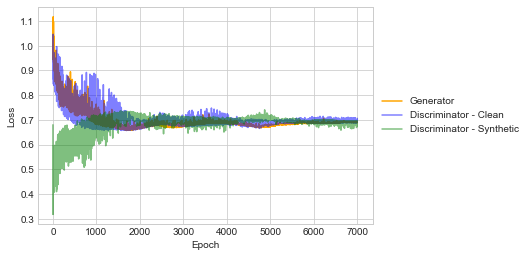

In [5]:
    gan.plot()
    from keras.utils import plot_model
    plot_model(gan.G, to_file='gen.png')
    plot_model(gan.D, to_file='dis.png')

In [60]:
#prediction = copy.deepcopy(gan.G.predict(scaled_data[0,:].reshape(10,)))
original = np.array([71.544037,107.316055,44.715023,218.146285,218.146285,106.706305,142.275074,2.540626,12.888000,0.960426])

scaled_original = scaler.transform(copy.deepcopy(original).reshape(1,10))
print(scaler.inverse_transform(scaled_original.reshape(1,10)).reshape(10,))

[ 71.544037 107.316055  44.715023 218.146285 218.146285 106.706305
 142.275074   2.540626  12.888      0.960426]


In [61]:
prediction = copy.deepcopy(gan.G.predict(scaled_original.reshape(1,10)))
scaled_prediction = scaler.inverse_transform(prediction.reshape(1,10)).reshape(10,)
print(scaled_prediction)


[ 79.9013      73.665985    44.863194   198.78651    196.11926
 179.04446     90.4493      11.947959     9.528958     0.92617655]


In [41]:
data

,0.5-1.0 (kg),0.25-0.5 (kg),GM (kg),Cement (kg),Slag (kg),Latex R (kg),Albitol (kg),Glenium (kg),F'c (MPa),Abs. Dens. (g/cm3)
0,103.875225,69.250150,43.281344,157.803867,157.803867,154.576228,77.288114,7.728811,9.612000,0.869864
1,123.913108,82.608739,36.445032,166.036828,166.036828,158.456660,79.228330,6.338266,6.517333,0.912498
2,155.658833,103.772555,28.825710,148.835193,148.835193,154.423445,77.211723,6.176938,7.272333,0.909079
3,69.857695,46.571797,49.898354,165.111060,165.111060,201.969527,71.283362,9.504448,5.669667,0.876499
4,68.108265,158.919286,40.063686,170.412563,170.412563,166.932023,83.466012,6.677281,9.504667,0.919380
5,99.056171,66.037447,41.273405,187.195501,187.195501,180.571145,77.387633,6.191011,7.297333,0.938735
6,116.872277,77.914851,48.696782,142.900429,142.900429,132.328212,79.396927,6.351754,9.630000,0.802933
7,145.767758,97.178505,42.872870,117.528177,117.528177,129.917788,77.950673,20.786846,7.513333,0.782821
8,72.923977,170.155946,42.896457,92.769850,92.769850,131.267847,70.322061,28.128824,0.000000,0.767660
9,58.444632,136.370809,48.703860,126.225436,126.225436,124.244542,74.546725,19.083962,5.539667,0.794701


[[103.8752255   69.25015037  43.28134398 157.8038672  157.8038672
  154.5762285   77.28811425   7.72881142   9.612        0.8698636 ]
 [123.913108    82.60873866  36.44503176 166.0368277  166.0368277
  158.4566598   79.22832992   6.33826639   6.51733333   0.91249763]
 [155.6588326  103.7725551   28.82570975 148.8351933  148.8351933
  154.4234451   77.21172253   6.1769378    7.27233333   0.90907908]
 [ 69.85769506  46.57179671  49.89835362 165.1110597  165.1110597
  201.9695265   71.28336231   9.50444831   5.66966667   0.87649881]
 [ 68.10826544 158.919286    40.06368555 170.4125625  170.4125625
  166.9320231   83.46601157   6.67728093   9.50466667   0.91938038]
 [ 99.05617084  66.03744722  41.27340451 187.1955013  187.1955013
  180.5711448   77.38763346   6.19101068   7.29733333   0.93873479]
 [116.872277    77.9148513   48.69678206 142.900429   142.900429
  132.3282121   79.39692728   6.35175418   9.63         0.80293315]
 [145.7677581   97.17850539  42.87287002 117.5281774  117.52817